My code builds a stacked ensemble model to predict explosive football plays using both player tracking data and engineered contextual features. I start by loading and cleaning the raw NFL tracking data, converting key columns to numeric values, and handling missing data. Then, I engineer higher-level features, such as the rusher’s position, the nearest defender’s distance, score differential, and yards to goal, which capture spatial, situational, and contextual aspects of each play. I standardize numerical variables and one-hot encode categorical variables to create a transformed feature matrix ready for modeling. The target variable, `IsExplosive`, flags plays gaining 10 or more yards, framing the task as a binary classification problem.

For modeling, I implement a stacked ensemble consisting of two base learners—a deep neural network (MLP) and an XGBoost classifier—trained using out-of-fold (OOF) predictions to improve robustness. These base models produce first-level features that I then feed into a meta-learner (a shallow XGBoost model), which learns how to optimally combine their outputs and captures any nonlinear interactions. I evaluate the final ensemble using an OOF ROC AUC score to assess predictive performance. Additionally, I include analysis to check whether a threshold of 150 carries per player is appropriate, using coverage metrics and AUC sensitivity plots to make sure the cutoff balances sufficient data inclusion with statistical stability.


In [ ]:
!pip install scikeras tensorflow scikit-learn xgboost scikit-learn

In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import warnings
from IPython.display import display, HTML

ModuleNotFoundError: No module named 'scikeras'

In [ ]:
# --- Global Config ---
RANDOM_STATE = 42
N_SPLITS = 5
EXPLOSIVE_YARDS_THRESHOLD = 10
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# ==============================================================
# I. DATA LOADING AND FEATURE ENGINEERING
# ==============================================================

print("--- Step 1: Loading and Feature Engineering ---")

# 1. Mount Drive and Load Data
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path, low_memory=False)

# 2. Data Cleaning
numeric_cols = ['X', 'Y', 'S', 'A', 'YardLine', 'Distance', 'Yards']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 3. Feature Engineering
def engineer_features(df):
    rusher_cols = [
        'PlayId', 'Yards', 'Down', 'Distance', 'YardLine', 'OffenseFormation',
        'DefendersInTheBox', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
        'PossessionTeam', 'HomeTeamAbbr', 'S', 'A', 'NflIdRusher', 'DisplayName'
    ]
    rusher_df = df[df['NflId'] == df['NflIdRusher']].drop_duplicates(subset=['PlayId'])[rusher_cols].copy()

    rusher_pos_xy = df[df['NflId'] == df['NflIdRusher']][['PlayId', 'X', 'Y']].drop_duplicates()
    rusher_pos_xy.rename(columns={'X': 'RusherX', 'Y': 'RusherY'}, inplace=True)
    df_merged = pd.merge(df, rusher_pos_xy, on='PlayId', how='left')

    defenders_df = df_merged[df_merged['Team'] != df_merged['PossessionTeam']].copy()
    defenders_df['DistToRusher'] = np.sqrt(
        (defenders_df['X'] - defenders_df['RusherX'])**2 + (defenders_df['Y'] - defenders_df['RusherY'])**2
    )
    defender_proximity = defenders_df.groupby('PlayId')['DistToRusher'].agg(MinDistToRusher=('min')).reset_index()

    model_df = pd.merge(rusher_df, defender_proximity, on='PlayId', how='left')
    model_df['ScoreDifferential'] = np.where(
        model_df['PossessionTeam'] == model_df['HomeTeamAbbr'],
        model_df['HomeScoreBeforePlay'] - model_df['VisitorScoreBeforePlay'],
        model_df['VisitorScoreBeforePlay'] - model_df['HomeScoreBeforePlay']
    )
    model_df['YardsToGoal'] = model_df['YardLine']
    model_df['IsExplosive'] = (model_df['Yards'] >= EXPLOSIVE_YARDS_THRESHOLD).astype(int)
    return model_df

model_data = engineer_features(df.copy())

# 4. Feature Selection
numerical_features = ['MinDistToRusher', 'YardsToGoal', 'ScoreDifferential', 'DefendersInTheBox', 'S', 'A', 'Distance']
categorical_features = ['Down', 'OffenseFormation']
context_features = ['NflIdRusher', 'DisplayName', 'PlayId', 'Yards', 'IsExplosive']

X_raw = model_data.drop(columns=context_features, errors='ignore')
Y_full = model_data['IsExplosive'].values

# 5. Preprocessing Pipeline
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ],
    remainder='drop'
)

X_full = full_preprocessor.fit_transform(X_raw)
N_FEATURES = X_full.shape[1]
print(f"✅ Input features transformed. Total features: {N_FEATURES}")

# ==============================================================
# II. MODEL BUILDING (Stacked Ensemble)
# ==============================================================

# 1. Keras MLP Builder
def create_mlp_model(input_dim, learning_rate=0.0005, dropout_rate=0.3, units=128):
    model = Sequential([
        Dense(units, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(units // 2, activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(units // 4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

# 2. Define Base Models
count_explosive = np.sum(Y_full == 1)
count_non_explosive = np.sum(Y_full == 0)
scale_weight = count_non_explosive / count_explosive

base_models_list = [
    ('MLPNN', KerasClassifier(
        model=lambda input_dim=N_FEATURES: create_mlp_model(input_dim),
        epochs=15, batch_size=64, verbose=0, random_state=RANDOM_STATE,
        fit__class_weight={0: 1, 1: scale_weight}
    )),
    ('XGBoost', xgb.XGBClassifier(
        objective='binary:logistic', n_estimators=300, max_depth=6, gamma=0.7,
        learning_rate=0.03, scale_pos_weight=scale_weight, random_state=RANDOM_STATE,
        use_label_encoder=False, eval_metric='logloss', n_jobs=-1
    ))
]

# 3. OOF Prediction Function
def generate_oof_predictions(base_models, X_full, Y_full, n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros((X_full.shape[0], len(base_models)))

    for fold, (train_index, val_index) in enumerate(kf.split(X_full, Y_full)):
        X_train, X_val = X_full[train_index], X_full[val_index]
        Y_train, Y_val = Y_full[train_index], Y_full[val_index]

        for i, (name, model) in enumerate(base_models):
            model_fold = clone(model)
            model_fold.fit(X_train, Y_train)
            oof_preds[val_index, i] = model_fold.predict_proba(X_val)[:, 1]

    return oof_preds

print("--- Step 3: Training Base Models via OOF ---")
X_level1 = generate_oof_predictions(base_models_list, X_full, Y_full)

print("--- Step 4: Training Meta-Learner (Shallow XGBoost) ---")

meta_learner = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=80,           # small ensemble for blending
    max_depth=2,               # shallow trees
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,            # L2 regularization
    reg_alpha=0.0,             # can increase to 0.1 if overfitting
    random_state=RANDOM_STATE,
    eval_metric='auc',
    n_jobs=-1
)

meta_learner.fit(X_level1, Y_full)
oof_score = roc_auc_score(Y_full, meta_learner.predict_proba(X_level1)[:, 1])

print(f"✅ Stacked Ensemble Training Complete. OOF ROC AUC (meta XGBoost): {oof_score:.4f}")

--- Step 1: Loading and Feature Engineering ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Input features transformed. Total features: 20
--- Step 3: Training Base Models via OOF ---
--- Step 4: Training Meta-Learner (Shallow XGBoost) ---
✅ Stacked Ensemble Training Complete. OOF ROC AUC (meta XGBoost): 0.6671


In [ ]:
# ==============================================================
# III. RUSHER-LEVEL AGGREGATION (BPR CALCULATION)
# ==============================================================

MIN_CARRIES_THRESHOLD = 150

final_stacked_proba = meta_learner.predict_proba(X_level1)[:, 1]
model_data['ProbExplosive'] = final_stacked_proba

rusher_bpr = model_data.groupby(['NflIdRusher']).agg(
    DisplayName=('DisplayName', 'first'),
    TotalCarries=('PlayId', 'count'),
    AvgPredictedBPR=('ProbExplosive', 'mean'),
    ActualBPR=('IsExplosive', 'mean')
).reset_index()

high_volume_rushers = rusher_bpr[
    rusher_bpr['TotalCarries'] >= MIN_CARRIES_THRESHOLD
].sort_values(by='TotalCarries', ascending=False).copy()

print("--- Final Rusher BPR Generation Complete ---")
print(f"Total rushers: {rusher_bpr.shape[0]}")
print(f"High-volume rushers (>= {MIN_CARRIES_THRESHOLD} carries): {high_volume_rushers.shape[0]}")

display(high_volume_rushers)

--- Final Rusher BPR Generation Complete ---
Total rushers: 443
High-volume rushers (>= 150 carries): 70


,NflIdRusher,DisplayName,TotalCarries,AvgPredictedBPR,ActualBPR
216,2555224,Ezekiel Elliott,751,0.103189,0.113182
181,2552475,Todd Gurley,667,0.103331,0.130435
233,2555418,Jordan Howard,637,0.108233,0.105181
286,2557973,Leonard Fournette,606,0.092211,0.085809
138,2543743,Carlos Hyde,581,0.099191,0.104991
...,...,...,...,...,...
180,2552471,T.J. Yeldon,160,0.109423,0.100000
89,2539265,Rex Burkhead,158,0.114211,0.082278
414,2562502,David Montgomery,156,0.097980,0.044872
167,2552382,Malcolm Brown,153,0.103433,0.104575


In [ ]:
# ==============================================================
# IV. DISPLAY TABLE FUNCTION
# ==============================================================

def display_epr_differential_table(rusher_bpr, min_carries=MIN_CARRIES_THRESHOLD):
    """
    Display rushers ranked by Explosive Play Rate differential.
    """
    EXPLOSIVE_YARDS_THRESHOLD = 10

    analysis_df = rusher_bpr[
        (rusher_bpr['TotalCarries'] >= min_carries) & (rusher_bpr['DisplayName'].notna())
    ].copy()

    analysis_df['EPR_Differential'] = analysis_df['ActualBPR'] - analysis_df['AvgPredictedBPR']
    table_data = analysis_df.sort_values(by='EPR_Differential', ascending=False).copy()

    EPR_ACTUAL_COL = f'Actual EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    EPR_PREDICTED_COL = f'Predicted EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    DIFFERENTIAL_COL = 'EPR Differential (Actual - Predicted)'

    table_for_display = table_data[[
        'DisplayName', 'TotalCarries', 'EPR_Differential', 'ActualBPR', 'AvgPredictedBPR'
    ]].rename(columns={
        'DisplayName': 'Rusher Name',
        'TotalCarries': 'Carries',
        'EPR_Differential': DIFFERENTIAL_COL,
        'ActualBPR': EPR_ACTUAL_COL,
        'AvgPredictedBPR': EPR_PREDICTED_COL
    }).reset_index(drop=True)

    styled_table = table_for_display.style.format({
        'Carries': '{:,.0f}',
        DIFFERENTIAL_COL: '{:+.2%}',
        EPR_ACTUAL_COL: '{:.2%}',
        EPR_PREDICTED_COL: '{:.2%}'
    }).background_gradient(
        cmap='coolwarm',
        subset=[DIFFERENTIAL_COL]
    ).set_caption(
        f"Running Backs Ranked by Explosive Value Added (Min {min_carries} Carries)"
    )

    display(styled_table)

# Example usage:
display_epr_differential_table(rusher_bpr)

,Rusher Name,Carries,EPR Differential (Actual - Predicted),Actual EPR (>10 Yds),Predicted EPR (>10 Yds)
0,Nick Chubb,412,+3.80%,13.59%,9.80%
1,Duke Johnson,181,+3.37%,14.92%,11.55%
2,Matt Breida,362,+3.01%,16.30%,13.29%
3,Todd Gurley,667,+2.71%,13.04%,10.33%
4,Giovani Bernard,197,+2.21%,13.20%,10.99%
5,James Conner,347,+2.04%,12.97%,10.93%
6,Melvin Gordon,555,+2.00%,12.07%,10.07%
7,Gus Edwards,222,+1.86%,13.06%,11.21%
8,Austin Ekeler,246,+1.80%,13.82%,12.02%
9,Derrick Henry,577,+1.73%,12.65%,10.92%


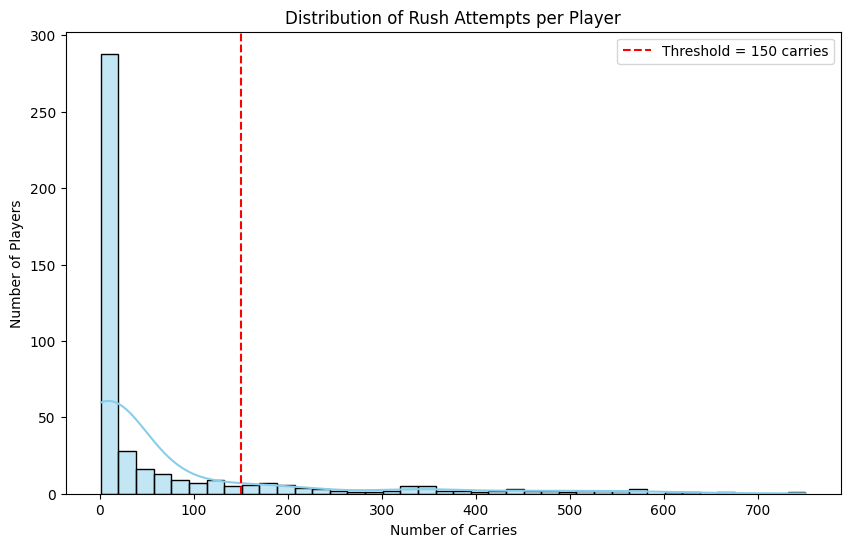

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count carries per player
carry_counts = df[df['NflId'] == df['NflIdRusher']].groupby('DisplayName')['PlayId'].count().reset_index()
carry_counts.columns = ['DisplayName', 'NumCarries']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(carry_counts['NumCarries'], bins=40, kde=True, color='skyblue')
plt.axvline(150, color='red', linestyle='--', label='Threshold = 150 carries')
plt.title('Distribution of Rush Attempts per Player')
plt.xlabel('Number of Carries')
plt.ylabel('Number of Players')
plt.legend()
plt.show()


In [ ]:
# What % of all plays are from players with >=150 carries?
eligible_players = carry_counts[carry_counts['NumCarries'] >= 150]['DisplayName']
coverage = df[df['DisplayName'].isin(eligible_players)].shape[0] / df.shape[0]

print(f"Players with >=150 carries: {len(eligible_players)}")
print(f"Data coverage: {coverage * 100:.2f}% of total plays")


Players with >=150 carries: 70
Data coverage: 3.73% of total plays


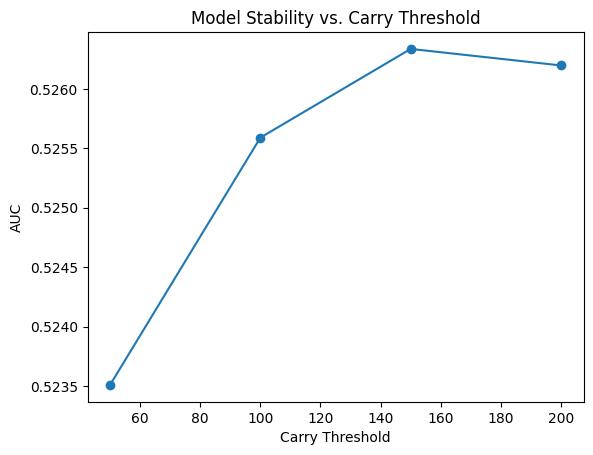

Threshold 50: 118 players | AUC = 0.5235
Threshold 100: 87 players | AUC = 0.5256
Threshold 150: 70 players | AUC = 0.5263
Threshold 200: 53 players | AUC = 0.5262


In [ ]:
thresholds = [50, 100, 150, 200]
results = []

for t in thresholds:
    eligible_players = carry_counts[carry_counts['NumCarries'] >= t]['DisplayName']
    filtered = model_data[model_data['DisplayName'].isin(eligible_players)]
    X_filtered = full_preprocessor.transform(filtered.drop(columns=context_features, errors='ignore'))
    y_filtered = filtered['IsExplosive']

    # simple baseline check with meta_learner or base model
    preds = meta_learner.predict_proba(X_filtered[:, :X_level1.shape[1]])[:, 1]
    auc = roc_auc_score(y_filtered, preds)
    results.append((t, len(eligible_players), auc))

# Plot AUC vs. threshold
thresholds, num_players, aucs = zip(*results)
plt.plot(thresholds, aucs, marker='o')
plt.xlabel("Carry Threshold")
plt.ylabel("AUC")
plt.title("Model Stability vs. Carry Threshold")
plt.show()

for t, n, auc in results:
    print(f"Threshold {t}: {n} players | AUC = {auc:.4f}")


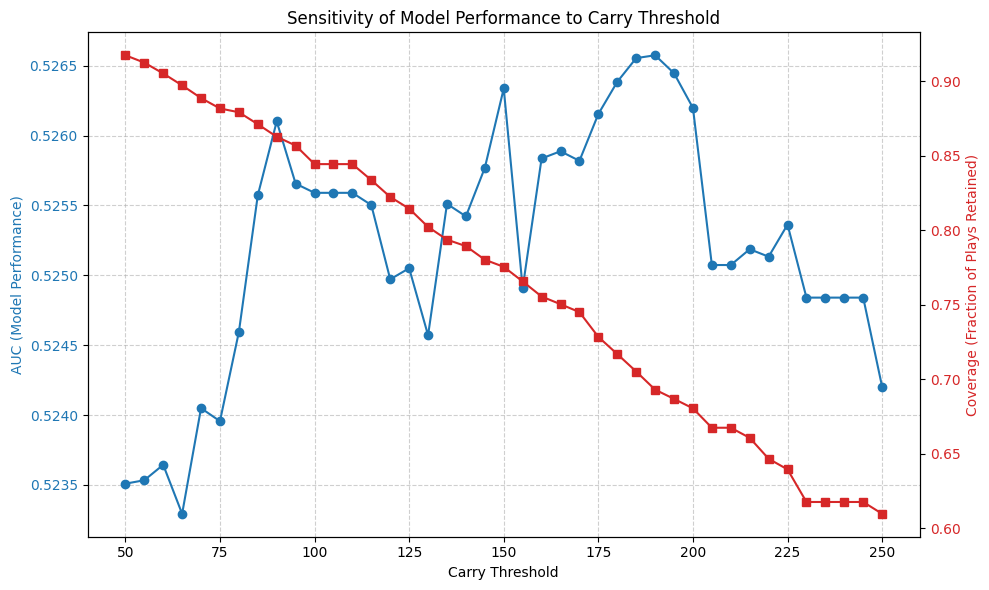

 Threshold  NumPlayers Coverage    AUC
        50         118   91.76% 0.5235
        55         115   91.26% 0.5235
        60         111   90.53% 0.5236
        65         107   89.73% 0.5233
        70         103   88.88% 0.5240
        75         100   88.18% 0.5240
        80          99   87.93% 0.5246
        85          96   87.13% 0.5256
        90          93   86.28% 0.5261
        95          91   85.69% 0.5257
       100          87   84.45% 0.5256
       105          87   84.45% 0.5256
       110          87   84.45% 0.5256
       115          84   83.37% 0.5255
       120          81   82.24% 0.5250
       125          79   81.46% 0.5251
       130          76   80.23% 0.5246
       135          74   79.37% 0.5255
       140          73   78.94% 0.5254
       145          71   78.02% 0.5258
       150          70   77.55% 0.5263
       155          68   76.57% 0.5249
       160          66   75.55% 0.5258
       165          65   75.04% 0.5259
       170          64   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# --- 1. Count carries per player ---
carry_counts = (
    df[df['NflId'] == df['NflIdRusher']]
    .groupby('DisplayName')['PlayId']
    .count()
    .reset_index()
    .rename(columns={'PlayId': 'NumCarries'})
)

# --- 2. Define fine-grained thresholds ---
thresholds = np.arange(50, 251, 5)  # 50, 75, 100, ..., 250
results = []

for t in thresholds:
    # Filter players with >= threshold carries
    eligible_players = carry_counts[carry_counts['NumCarries'] >= t]['DisplayName']
    filtered = model_data[model_data['DisplayName'].isin(eligible_players)]

    # Skip thresholds that leave too little data
    if len(filtered) < 500:
        continue

    # Transform data using your fitted preprocessor
    X_filtered = full_preprocessor.transform(filtered.drop(columns=context_features, errors='ignore'))
    y_filtered = filtered['IsExplosive'].values

    # Predict using your trained meta_learner (from stacking)
    preds = meta_learner.predict_proba(X_filtered[:, :X_level1.shape[1]])[:, 1]
    auc = roc_auc_score(y_filtered, preds)

    # Compute data coverage
    coverage = len(filtered) / len(model_data)
    results.append((t, len(eligible_players), coverage, auc))

# --- 3. Convert results to DataFrame ---
results_df = pd.DataFrame(results, columns=['Threshold', 'NumPlayers', 'Coverage', 'AUC'])

# --- 4. Plot Results ---
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel('Carry Threshold')
ax1.set_ylabel('AUC (Model Performance)', color=color)
ax1.plot(results_df['Threshold'], results_df['AUC'], marker='o', color=color, label='AUC')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coverage (Fraction of Plays Retained)', color=color)
ax2.plot(results_df['Threshold'], results_df['Coverage'], marker='s', color=color, label='Coverage')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Sensitivity of Model Performance to Carry Threshold')
fig.tight_layout()
plt.show()

# --- 5. Print summary table ---
print(results_df.to_string(index=False, formatters={
    'Coverage': '{:.2%}'.format,
    'AUC': '{:.4f}'.format
}))


Alternate Pipeline Method

In [ ]:
!pip install scikeras ten

In [ ]:
# --- Global Config ---
RANDOM_STATE = 42
N_SPLITS = 5
EXPLOSIVE_YARDS_THRESHOLD = 10
TOP_FEATURES = 30  # number of top features to keep
#warnings.filterwarnings('ignore', category=UserWarning)
#warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# ==============================================================
# I. DATA LOADING AND FEATURE ENGINEERING
# ==============================================================

print("--- Step 1: Loading and Feature Engineering ---")

# 1. Mount Drive and Load Data
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path, low_memory=False)

# 2. Data Cleaning
numeric_cols = ['X', 'Y', 'S', 'A', 'YardLine', 'Distance', 'Yards']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 3. Feature Engineering
def engineer_features(df):
    rusher_cols = [
        'PlayId', 'Yards', 'Down', 'Distance', 'YardLine', 'OffenseFormation',
        'DefendersInTheBox', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
        'PossessionTeam', 'HomeTeamAbbr', 'S', 'A', 'NflIdRusher', 'DisplayName'
    ]
    rusher_df = df[df['NflId'] == df['NflIdRusher']].drop_duplicates(subset=['PlayId'])[rusher_cols].copy()

    rusher_pos_xy = df[df['NflId'] == df['NflIdRusher']][['PlayId', 'X', 'Y']].drop_duplicates()
    rusher_pos_xy.rename(columns={'X': 'RusherX', 'Y': 'RusherY'}, inplace=True)
    df_merged = pd.merge(df, rusher_pos_xy, on='PlayId', how='left')

    defenders_df = df_merged[df_merged['Team'] != df_merged['PossessionTeam']].copy()
    defenders_df['DistToRusher'] = np.sqrt(
        (defenders_df['X'] - defenders_df['RusherX'])**2 + (defenders_df['Y'] - defenders_df['RusherY'])**2
    )
    defender_proximity = defenders_df.groupby('PlayId')['DistToRusher'].agg(MinDistToRusher=('min')).reset_index()

    model_df = pd.merge(rusher_df, defender_proximity, on='PlayId', how='left')
    model_df['ScoreDifferential'] = np.where(
        model_df['PossessionTeam'] == model_df['HomeTeamAbbr'],
        model_df['HomeScoreBeforePlay'] - model_df['VisitorScoreBeforePlay'],
        model_df['VisitorScoreBeforePlay'] - model_df['HomeScoreBeforePlay']
    )
    model_df['YardsToGoal'] = model_df['YardLine']
    model_df['IsExplosive'] = (model_df['Yards'] >= EXPLOSIVE_YARDS_THRESHOLD).astype(int)
    return model_df

model_data = engineer_features(df.copy())

# 4. Feature Selection
numerical_features = ['MinDistToRusher', 'YardsToGoal', 'ScoreDifferential', 'DefendersInTheBox', 'S', 'A', 'Distance']
categorical_features = ['Down', 'OffenseFormation']
context_features = ['NflIdRusher', 'DisplayName', 'PlayId', 'Yards', 'IsExplosive']

X_raw = model_data.drop(columns=context_features, errors='ignore')
Y_full = model_data['IsExplosive'].values

# 5. Add Interaction Features
X_raw['S*A'] = X_raw['S'] * X_raw['A']
X_raw['S^2'] = X_raw['S'] ** 2
X_raw['A^2'] = X_raw['A'] ** 2
X_raw['MinDistToRusher^2'] = X_raw['MinDistToRusher'] ** 2
numerical_features += ['S*A', 'S^2', 'A^2', 'MinDistToRusher^2']

# 6. Preprocessing
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ],
    remainder='drop'
)

X_full = full_preprocessor.fit_transform(X_raw)
N_FEATURES = X_full.shape[1]
print(f"✅ Input features transformed. Total features: {N_FEATURES}")

# ==============================================================
# II. FEATURE IMPORTANCE-BASED PRUNING
# ==============================================================

print("--- Step 2: Selecting Top Features via XGBoost Importance ---")

xgb_temp = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    eval_metric='auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_temp.fit(X_full, Y_full)

# Get feature importances
importances = xgb_temp.feature_importances_
feature_indices = np.argsort(importances)[::-1][:TOP_FEATURES]
X_full_selected = X_full[:, feature_indices]

print(f"✅ Selected top {TOP_FEATURES} features for training (reduced from {N_FEATURES})")

# ==============================================================
# III. MODEL BUILDING (Stacked Ensemble)
# ==============================================================

# 1. Keras MLP Builder
def create_mlp_model(input_dim, learning_rate=0.0005, dropout_rate=0.3, units=128):
    model = Sequential([
        Dense(units, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(units // 2, activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(units // 4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

# 2. Define Base Models
count_explosive = np.sum(Y_full == 1)
count_non_explosive = np.sum(Y_full == 0)
scale_weight = count_non_explosive / count_explosive

base_models_list = [
    ('MLPNN', KerasClassifier(
        model=lambda input_dim=X_full_selected.shape[1]: create_mlp_model(input_dim),
        epochs=20, batch_size=64, verbose=0, random_state=RANDOM_STATE,
        fit__class_weight={0: 1, 1: scale_weight}
    )),
    ('XGBoost', xgb.XGBClassifier(
        objective='binary:logistic', n_estimators=400, max_depth=7, gamma=0.5,
        learning_rate=0.025, scale_pos_weight=scale_weight, random_state=RANDOM_STATE,
        use_label_encoder=False, eval_metric='logloss', n_jobs=-1
    ))
]

# 3. OOF Prediction Function
def generate_oof_predictions(base_models, X_full, Y_full, n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros((X_full.shape[0], len(base_models)))

    for fold, (train_index, val_index) in enumerate(kf.split(X_full, Y_full)):
        X_train, X_val = X_full[train_index], X_full[val_index]
        Y_train, Y_val = Y_full[train_index], Y_full[val_index]

        for i, (name, model) in enumerate(base_models):
            model_fold = clone(model)
            model_fold.fit(X_train, Y_train)
            oof_preds[val_index, i] = model_fold.predict_proba(X_val)[:, 1]

    return oof_preds

print("--- Step 3: Training Base Models via OOF ---")
X_level1 = generate_oof_predictions(base_models_list, X_full_selected, Y_full)

print("--- Step 4: Training Meta-Learner (Tuned XGBoost) ---")

meta_learner = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=1.2,
    reg_alpha=0.1,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    n_jobs=-1
)

meta_learner.fit(X_level1, Y_full)
oof_score = roc_auc_score(Y_full, meta_learner.predict_proba(X_level1)[:, 1])

print(f"✅ Stacked Ensemble Complete. OOF ROC AUC (meta XGBoost): {oof_score:.4f}")


--- Step 1: Loading and Feature Engineering ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Input features transformed. Total features: 24
--- Step 2: Selecting Top Features via XGBoost Importance ---
✅ Selected top 30 features for training (reduced from 24)
--- Step 3: Training Base Models via OOF ---
--- Step 4: Training Meta-Learner (Tuned XGBoost) ---
✅ Stacked Ensemble Complete. OOF ROC AUC (meta XGBoost): 0.6690


In [ ]:
# --- III. RUSHER-LEVEL AGGREGATION (BPR CALCULATION) ---
MIN_CARRIES_THRESHOLD = 150

# Use predictions from the meta-learner
final_stacked_proba = meta_learner.predict_proba(X_level1)[:, 1]
model_data['ProbExplosive'] = final_stacked_proba

# Aggregate per rusher
rusher_bpr = model_data.groupby(['NflIdRusher']).agg(
    DisplayName=('DisplayName', 'first'),
    TotalCarries=('PlayId', 'count'),
    AvgPredictedBPR=('ProbExplosive', 'mean'),
    ActualBPR=('IsExplosive', 'mean')
).reset_index()

# Filter high-volume rushers
high_volume_rushers = rusher_bpr[
    rusher_bpr['TotalCarries'] >= MIN_CARRIES_THRESHOLD
].sort_values(by='TotalCarries', ascending=False).copy()

print("--- Final Rusher BPR Generation Complete ---")
print(f"Total rushers: {rusher_bpr.shape[0]}")
print(f"High-volume rushers (>= {MIN_CARRIES_THRESHOLD} carries): {high_volume_rushers.shape[0]}")

display(high_volume_rushers)


--- Final Rusher BPR Generation Complete ---
Total rushers: 443
High-volume rushers (>= 150 carries): 70


,NflIdRusher,DisplayName,TotalCarries,AvgPredictedBPR,ActualBPR
216,2555224,Ezekiel Elliott,751,0.103715,0.113182
181,2552475,Todd Gurley,667,0.104627,0.130435
233,2555418,Jordan Howard,637,0.108178,0.105181
286,2557973,Leonard Fournette,606,0.092176,0.085809
138,2543743,Carlos Hyde,581,0.099866,0.104991
...,...,...,...,...,...
180,2552471,T.J. Yeldon,160,0.108889,0.100000
89,2539265,Rex Burkhead,158,0.113616,0.082278
414,2562502,David Montgomery,156,0.097931,0.044872
167,2552382,Malcolm Brown,153,0.101307,0.104575


In [ ]:
# --- IV. DISPLAY TABLE FUNCTION ---
def display_epr_differential_table(rusher_bpr, min_carries=MIN_CARRIES_THRESHOLD):
    """
    Display rushers ranked by Explosive Play Rate differential.
    """
    EXPLOSIVE_YARDS_THRESHOLD = 10

    analysis_df = rusher_bpr[
        (rusher_bpr['TotalCarries'] >= min_carries) & (rusher_bpr['DisplayName'].notna())
    ].copy()

    analysis_df['EPR_Differential'] = analysis_df['ActualBPR'] - analysis_df['AvgPredictedBPR']
    table_data = analysis_df.sort_values(by='EPR_Differential', ascending=False).copy()

    EPR_ACTUAL_COL = f'Actual EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    EPR_PREDICTED_COL = f'Predicted EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    DIFFERENTIAL_COL = 'EPR Differential (Actual - Predicted)'

    table_for_display = table_data[[
        'DisplayName', 'TotalCarries', 'EPR_Differential', 'ActualBPR', 'AvgPredictedBPR'
    ]].rename(columns={
        'DisplayName': 'Rusher Name',
        'TotalCarries': 'Carries',
        'EPR_Differential': DIFFERENTIAL_COL,
        'ActualBPR': EPR_ACTUAL_COL,
        'AvgPredictedBPR': EPR_PREDICTED_COL
    }).reset_index(drop=True)

    styled_table = table_for_display.style.format({
        'Carries': '{:,.0f}',
        DIFFERENTIAL_COL: '{:+.2%}',
        EPR_ACTUAL_COL: '{:.2%}',
        EPR_PREDICTED_COL: '{:.2%}'
    }).background_gradient(
        cmap='coolwarm',
        subset=[DIFFERENTIAL_COL]
    ).set_caption(
        f"Running Backs Ranked by Explosive Value Added (Min {min_carries} Carries)"
    )

    display(styled_table)

# Example usage
display_epr_differential_table(rusher_bpr)


,Rusher Name,Carries,EPR Differential (Actual - Predicted),Actual EPR (>10 Yds),Predicted EPR (>10 Yds)
0,Nick Chubb,412,+3.87%,13.59%,9.73%
1,Duke Johnson,181,+3.32%,14.92%,11.60%
2,Matt Breida,362,+3.01%,16.30%,13.29%
3,Todd Gurley,667,+2.58%,13.04%,10.46%
4,James Conner,347,+2.11%,12.97%,10.86%
5,Giovani Bernard,197,+2.09%,13.20%,11.11%
6,Austin Ekeler,246,+2.00%,13.82%,11.82%
7,Gus Edwards,222,+2.00%,13.06%,11.06%
8,Melvin Gordon,555,+1.93%,12.07%,10.14%
9,Bilal Powell,279,+1.78%,11.47%,9.69%


In [ ]:
# --- Global Config ---
RANDOM_STATE = 42
N_SPLITS = 5
EXPLOSIVE_YARDS_THRESHOLD = 10
TOP_FEATURES = 30
MIN_CARRIES_THRESHOLD = 150
#warnings.filterwarnings('ignore', category=UserWarning)
#warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# ==============================================================
# I. DATA LOADING AND FEATURE ENGINEERING
# ==============================================================

print("--- Step 1: Loading and Feature Engineering ---")

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path, low_memory=False)

numeric_cols = ['X', 'Y', 'S', 'A', 'YardLine', 'Distance', 'Yards']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

def engineer_features(df):
    #extracting rusher level info
    rusher_cols = [
        'PlayId', 'Yards', 'Down', 'Distance', 'YardLine', 'OffenseFormation',
        'DefendersInTheBox', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
        'PossessionTeam', 'HomeTeamAbbr', 'S', 'A', 'NflIdRusher', 'DisplayName'
    ]
    rusher_df = df[df['NflId'] == df['NflIdRusher']].drop_duplicates(subset=['PlayId'])[rusher_cols].copy()
    #raw features such S, A, Down, YardLine, etc.

    #rusher position to find defender distance
    rusher_pos_xy = df[df['NflId'] == df['NflIdRusher']][['PlayId', 'X', 'Y']].drop_duplicates()
    rusher_pos_xy.rename(columns={'X':'RusherX','Y':'RusherY'}, inplace=True)
    df_merged = pd.merge(df, rusher_pos_xy, on='PlayId', how='left')

    #calculate defender proximity
    defenders_df = df_merged[df_merged['Team'] != df_merged['PossessionTeam']].copy()
    defenders_df['DistToRusher'] = np.sqrt((defenders_df['X']-defenders_df['RusherX'])**2 + (defenders_df['Y']-defenders_df['RusherY'])**2)
    defender_proximity = defenders_df.groupby('PlayId')['DistToRusher'].agg(MinDistToRusher=('min')).reset_index()
    # -> min distance to rusher

    #score differential as one of the contextual features
    model_df = pd.merge(rusher_df, defender_proximity, on='PlayId', how='left')
    model_df['ScoreDifferential'] = np.where(
        model_df['PossessionTeam']==model_df['HomeTeamAbbr'],
        model_df['HomeScoreBeforePlay']-model_df['VisitorScoreBeforePlay'],
        model_df['VisitorScoreBeforePlay']-model_df['HomeScoreBeforePlay']
    )

    #distance to the goal line
    model_df['YardsToGoal'] = model_df['YardLine']

    #target variable
    model_df['IsExplosive'] = (model_df['Yards']>=EXPLOSIVE_YARDS_THRESHOLD).astype(int)
    return model_df

model_data = engineer_features(df.copy())

# ==============================================================
# CNN FIELD TENSOR CONSTRUCTION
# ==============================================================

FIELD_LENGTH = 120
FIELD_WIDTH = 53.3
GRID_HEIGHT = 32
GRID_WIDTH = 32
NUM_CHANNELS = 4   # rusher, defenders, S, A

def create_field_tensor(original_df):
    plays = original_df['PlayId'].unique()
    tensor = np.zeros((len(plays), GRID_HEIGHT, GRID_WIDTH, NUM_CHANNELS), dtype=np.float32)
    labels = []

    # Extract rusher XY for each play
    rusher_xy = df[df['NflId'] == df['NflIdRusher']][['PlayId','X','Y']].drop_duplicates()
    rusher_xy.rename(columns={'X':'RusherX','Y':'RusherY'}, inplace=True)
    merged = pd.merge(df, rusher_xy, on='PlayId', how='left')

    for i, pid in enumerate(plays):
        play_df = merged[merged['PlayId']==pid]
        model_row = model_data[model_data['PlayId']==pid].iloc[0]

        # label
        labels.append(model_row['IsExplosive'])

        # bins
        xb = np.clip((play_df['X']/FIELD_LENGTH * GRID_WIDTH).astype(int), 0, GRID_WIDTH-1)
        yb = np.clip((play_df['Y']/FIELD_WIDTH * GRID_HEIGHT).astype(int), 0, GRID_HEIGHT-1)

        # Channel 0: rusher
        mask = play_df['NflId']==play_df['NflIdRusher']
        for x,y in zip(xb[mask], yb[mask]):
            tensor[i,y,x,0] = 1.0

        # Channel 1: defenders dist
        defenders = play_df[~mask].copy()
        defenders['Dist'] = np.sqrt((defenders['X']-play_df[mask]['RusherX'].values[0])**2 +
                                    (defenders['Y']-play_df[mask]['RusherY'].values[0])**2)
        for x,y,d in zip(xb[~mask], yb[~mask], defenders['Dist']):
            tensor[i,y,x,1] = d/50.0

        # Channel 2: speed S
        for x,y,s in zip(xb, yb, play_df['S']):
            tensor[i,y,x,2] = s/12.0

        # Channel 3: acceleration A
        for x,y,a in zip(xb, yb, play_df['A']):
            tensor[i,y,x,3] = a/6.0

    return tensor, np.array(labels)

X_cnn, Y_cnn = create_field_tensor(df)
print("CNN tensor:", X_cnn.shape, "Labels:", Y_cnn.shape)

numerical_features = ['MinDistToRusher','YardsToGoal','ScoreDifferential','DefendersInTheBox','S','A','Distance']
categorical_features = ['Down','OffenseFormation']
context_features = ['NflIdRusher','DisplayName','PlayId','Yards','IsExplosive']

X_raw = model_data.drop(columns=context_features, errors='ignore')
Y_full = model_data['IsExplosive'].values

# Interaction & normalized features
X_raw['S*A'] = X_raw['S']*X_raw['A'] # motion interaction
X_raw['S^2'] = X_raw['S']**2 #non-linear speed
X_raw['A^2'] = X_raw['A']**2 #non-linear acceleration
X_raw['MinDistToRusher^2'] = X_raw['MinDistToRusher']**2
X_raw['S/MinDistToRusher'] = X_raw['S']/np.clip(X_raw['MinDistToRusher'],1e-3,None) #non-linear defensive distance
X_raw['Distance/YardLine'] = X_raw['Distance']/np.clip(X_raw['YardLine'],1e-3,None) #speed to pressure ratio
numerical_features += ['S*A','S^2','A^2','MinDistToRusher^2','S/MinDistToRusher','Distance/YardLine'] #normalized play difficulty

#All of preprocessing is done here
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())]), numerical_features),
        ('cat', Pipeline([('imputer',SimpleImputer(strategy='constant',fill_value='missing')),('encoder',OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ], remainder='drop'
)

X_full = full_preprocessor.fit_transform(X_raw)
N_FEATURES = X_full.shape[1]
print(f"Input features transformed. Total features: {N_FEATURES}")

# ==============================================================
# II. FEATURE IMPORTANCE PRUNING
# ==============================================================

print("--- Step 2: Top Features via XGBoost ---")
xgb_temp = xgb.XGBClassifier(objective='binary:logistic', n_estimators=150, max_depth=5, learning_rate=0.05,
                             eval_metric='auc', random_state=RANDOM_STATE, n_jobs=-1)
xgb_temp.fit(X_full,Y_full)
importances = xgb_temp.feature_importances_
feature_indices = np.argsort(importances)[::-1][:TOP_FEATURES]
X_full_selected = X_full[:,feature_indices]
print(f"Selected top {TOP_FEATURES} features")

# ==============================================================
# III. STACKED ENSEMBLE
# ==============================================================

def create_mlp_model(input_dim, learning_rate=0.0005, dropout_rate=0.3, units=128):
    model = Sequential([
        BatchNormalization(input_shape=(input_dim,)),
        Dense(units,activation='relu'),
        Dropout(dropout_rate),
        Dense(units//2,activation='relu'),
        Dropout(dropout_rate/2),
        Dense(units//4,activation='relu'),
        Dense(1,activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

count_explosive = np.sum(Y_full==1)
count_non_explosive = np.sum(Y_full==0)
scale_weight = count_non_explosive/count_explosive

base_models_list = [
    ('MLPNN', KerasClassifier(model=lambda input_dim=X_full_selected.shape[1]: create_mlp_model(input_dim),
                              epochs=30,batch_size=64,verbose=0,random_state=RANDOM_STATE,
                              fit__class_weight={0:1,1:scale_weight})),
    ('XGBoost', xgb.XGBClassifier(objective='binary:logistic', n_estimators=400, max_depth=6, gamma=0.5,
                                  learning_rate=0.025, scale_pos_weight=scale_weight, random_state=RANDOM_STATE,
                                  use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('RandomForest', RandomForestClassifier(n_estimators=200,max_depth=10,min_samples_leaf=3,
                                           class_weight={0:1,1:scale_weight},random_state=RANDOM_STATE,n_jobs=-1))
]

def generate_oof_predictions(base_models, X_full, Y_full, n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros((X_full.shape[0],len(base_models)))
    for fold,(train_index,val_index) in enumerate(kf.split(X_full,Y_full)):
        X_train,X_val = X_full[train_index], X_full[val_index]
        Y_train,Y_val = Y_full[train_index], Y_full[val_index]
        for i,(name,model) in enumerate(base_models):
            model_fold = clone(model)
            model_fold.fit(X_train,Y_train)
            oof_preds[val_index,i] = model_fold.predict_proba(X_val)[:,1]
    return oof_preds

print("--- Step 3: Training Base Models via OOF ---")
X_level1 = generate_oof_predictions(base_models_list, X_full_selected, Y_full)

print("--- Step 4: Training Meta-Learner ---")
meta_learner = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200,max_depth=4,
                                 learning_rate=0.03,subsample=0.85,colsample_bytree=0.9,
                                 reg_lambda=1.2,reg_alpha=0.1,random_state=RANDOM_STATE,
                                 eval_metric='auc',n_jobs=-1)
meta_learner.fit(X_level1,Y_full)
oof_score = roc_auc_score(Y_full,meta_learner.predict_proba(X_level1)[:,1])
print(f"Stacked Ensemble OOF ROC AUC: {oof_score:.4f}")

# ==============================================================
# IV. RUSHER-LEVEL AGGREGATION & DISPLAY
# ==============================================================

final_stacked_proba = meta_learner.predict_proba(X_level1)[:,1]
model_data['ProbExplosive'] = final_stacked_proba

rusher_bpr = model_data.groupby(['NflIdRusher']).agg(
    DisplayName=('DisplayName','first'),
    TotalCarries=('PlayId','count'),
    AvgPredictedBPR=('ProbExplosive','mean'),
    ActualBPR=('IsExplosive','mean')
).reset_index()

high_volume_rushers = rusher_bpr[rusher_bpr['TotalCarries']>=MIN_CARRIES_THRESHOLD].sort_values(by='TotalCarries',ascending=False).copy()

print("--- Final Rusher BPR Complete ---")
print(f"Total rushers: {rusher_bpr.shape[0]}")
print(f"High-volume rushers: {high_volume_rushers.shape[0]}")

# Display function
def display_epr_differential_table(rusher_bpr,min_carries=MIN_CARRIES_THRESHOLD):
    EXPLOSIVE_YARDS_THRESHOLD = 10
    analysis_df = rusher_bpr[(rusher_bpr['TotalCarries']>=min_carries)&(rusher_bpr['DisplayName'].notna())].copy()
    analysis_df['EPR_Differential'] = analysis_df['ActualBPR']-analysis_df['AvgPredictedBPR']
    table_data = analysis_df.sort_values(by='EPR_Differential',ascending=False).copy()

    EPR_ACTUAL_COL = f'Actual EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    EPR_PREDICTED_COL = f'Predicted EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    DIFFERENTIAL_COL = 'EPR Differential (Actual - Predicted)'

    table_for_display = table_data[['DisplayName','TotalCarries','EPR_Differential','ActualBPR','AvgPredictedBPR']].rename(columns={
        'DisplayName':'Rusher Name','TotalCarries':'Carries','EPR_Differential':DIFFERENTIAL_COL,
        'ActualBPR':EPR_ACTUAL_COL,'AvgPredictedBPR':EPR_PREDICTED_COL
    }).reset_index(drop=True)

    styled_table = table_for_display.style.format({
        'Carries':'{:,.0f}',DIFFERENTIAL_COL:'{:+.2%}',EPR_ACTUAL_COL:'{:.2%}',EPR_PREDICTED_COL:'{:.2%}'
    }).background_gradient(cmap='coolwarm',subset=[DIFFERENTIAL_COL]).set_caption(
        f"Running Backs Ranked by Explosive Value Added (Min {min_carries} Carries)"
    )
    display(styled_table)

display_epr_differential_table(rusher_bpr)


--- Step 1: Loading and Feature Engineering ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input features transformed. Total features: 26
--- Step 2: Top Features via XGBoost ---
Selected top 30 features
--- Step 3: Training Base Models via OOF ---
--- Step 4: Training Meta-Learner ---
Stacked Ensemble OOF ROC AUC: 0.6895
--- Final Rusher BPR Complete ---
Total rushers: 443
High-volume rushers: 70


,Rusher Name,Carries,EPR Differential (Actual - Predicted),Actual EPR (>10 Yds),Predicted EPR (>10 Yds)
0,Nick Chubb,412,+3.69%,13.59%,9.90%
1,Duke Johnson,181,+3.46%,14.92%,11.46%
2,Matt Breida,362,+3.14%,16.30%,13.15%
3,Todd Gurley,667,+2.71%,13.04%,10.34%
4,Giovani Bernard,197,+2.13%,13.20%,11.07%
5,Melvin Gordon,555,+2.05%,12.07%,10.02%
6,Austin Ekeler,246,+1.96%,13.82%,11.87%
7,James Conner,347,+1.95%,12.97%,11.02%
8,Derrick Henry,577,+1.63%,12.65%,11.02%
9,Bilal Powell,279,+1.60%,11.47%,9.87%


In [ ]:
!pip install scikeras tensorflow

In [ ]:
# === REQUIRED IMPORTS ===
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
import tensorflow as tf

# --- Global Config ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
N_SPLITS = 5
EXPLOSIVE_YARDS_THRESHOLD = 10
TOP_FEATURES = 30
MIN_CARRIES_THRESHOLD = 150

# ==============================================================
# I. DATA LOADING AND FEATURE ENGINEERING
# ==============================================================
print("--- Step 1: Loading and Feature Engineering ---")
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path, low_memory=False)

numeric_cols = ['X', 'Y', 'S', 'A', 'YardLine', 'Distance', 'Yards']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

def engineer_features(df):
    rusher_cols = [
        'PlayId', 'Yards', 'Down', 'Distance', 'YardLine', 'OffenseFormation',
        'DefendersInTheBox', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
        'PossessionTeam', 'HomeTeamAbbr', 'S', 'A', 'NflIdRusher', 'DisplayName'
    ]
    rusher_df = df[df['NflId'] == df['NflIdRusher']].drop_duplicates(subset=['PlayId'])[rusher_cols].copy()
    rusher_pos_xy = df[df['NflId'] == df['NflIdRusher']][['PlayId', 'X', 'Y']].drop_duplicates()
    rusher_pos_xy.rename(columns={'X':'RusherX','Y':'RusherY'}, inplace=True)
    df_merged = pd.merge(df, rusher_pos_xy, on='PlayId', how='left')
    defenders_df = df_merged[df_merged['Team'] != df_merged['PossessionTeam']].copy()
    defenders_df['DistToRusher'] = np.sqrt((defenders_df['X']-defenders_df['RusherX'])**2 + (defenders_df['Y']-defenders_df['RusherY'])**2)
    defender_proximity = defenders_df.groupby('PlayId')['DistToRusher'].agg(MinDistToRusher=('min')).reset_index()
    model_df = pd.merge(rusher_df, defender_proximity, on='PlayId', how='left')
    model_df['ScoreDifferential'] = np.where(
        model_df['PossessionTeam']==model_df['HomeTeamAbbr'],
        model_df['HomeScoreBeforePlay']-model_df['VisitorScoreBeforePlay'],
        model_df['VisitorScoreBeforePlay']-model_df['HomeScoreBeforePlay']
    )
    model_df['YardsToGoal'] = model_df['YardLine']
    model_df['IsExplosive'] = (model_df['Yards']>=EXPLOSIVE_YARDS_THRESHOLD).astype(int)
    return model_df

model_data = engineer_features(df.copy())

# ==============================================================
# CNN FIELD TENSOR CONSTRUCTION
# ==============================================================
FIELD_LENGTH = 120.0
FIELD_WIDTH = 53.3
GRID_HEIGHT = 32
GRID_WIDTH = 32
NUM_CHANNELS = 4

def create_field_tensor_from_model_data(df_all, model_data_subset):
    plays = model_data_subset['PlayId'].values
    n = len(plays)
    tensor = np.zeros((n, GRID_HEIGHT, GRID_WIDTH, NUM_CHANNELS), dtype=np.float32)
    labels = np.zeros(n, dtype=int)
    rusher_pos = df_all[df_all['NflId'] == df_all['NflIdRusher']][['PlayId','X','Y']].drop_duplicates().set_index('PlayId')
    for i, pid in enumerate(plays):
        play_rows = df_all[df_all['PlayId'] == pid]
        labels[i] = int(model_data_subset.loc[model_data_subset['PlayId']==pid, 'IsExplosive'].values[0])
        if pid in rusher_pos.index:
            rusher_x = rusher_pos.at[pid, 'X']
            rusher_y = rusher_pos.at[pid, 'Y']
        else:
            rmask = play_rows['NflId'] == play_rows['NflIdRusher']
            rusher_x = play_rows[rmask]['X'].iloc[0] if rmask.any() else np.nan
            rusher_y = play_rows[rmask]['Y'].iloc[0] if rmask.any() else np.nan
        xb = np.clip((play_rows['X'] / FIELD_LENGTH * GRID_WIDTH).fillna(0).astype(int), 0, GRID_WIDTH-1)
        yb = np.clip((play_rows['Y'] / FIELD_WIDTH * GRID_HEIGHT).fillna(0).astype(int), 0, GRID_HEIGHT-1)
        rmask = play_rows['NflId'] == play_rows['NflIdRusher']
        for x,y in zip(xb[rmask], yb[rmask]):
            tensor[i,y,x,0] = 1.0
        if not np.isnan(rusher_x) and not np.isnan(rusher_y):
            defenders = play_rows[~rmask].copy()
            defenders_dist = np.sqrt((defenders['X'] - rusher_x)**2 + (defenders['Y'] - rusher_y)**2)
            for x,y,d in zip(xb[~rmask], yb[~rmask], defenders_dist):
                cur = tensor[i,y,x,1]
                val = d / 50.0
                tensor[i,y,x,1] = val if cur==0 else min(cur,val)
        for x,y,s in zip(xb, yb, play_rows['S']):
            tensor[i,y,x,2] = max(tensor[i,y,x,2], float(s) / 12.0)
        for x,y,a in zip(xb, yb, play_rows['A']):
            tensor[i,y,x,3] = max(tensor[i,y,x,3], float(a) / 6.0)
    return tensor, labels

X_cnn, Y_cnn = create_field_tensor_from_model_data(df, model_data)
print("CNN tensor shape (plays x H x W x C):", X_cnn.shape)
print("CNN labels shape:", Y_cnn.shape)

# ==============================================================
# TABULAR INPUT PREP
# ==============================================================
numerical_features = ['MinDistToRusher','YardsToGoal','ScoreDifferential','DefendersInTheBox','S','A','Distance']
categorical_features = ['Down','OffenseFormation']
context_features = ['NflIdRusher','DisplayName','PlayId','Yards','IsExplosive']

X_raw = model_data.drop(columns=context_features, errors='ignore')
Y_full = model_data['IsExplosive'].values

X_raw['S*A'] = X_raw['S'] * X_raw['A']
X_raw['S^2'] = X_raw['S'] ** 2
X_raw['A^2'] = X_raw['A'] ** 2
X_raw['MinDistToRusher^2'] = X_raw['MinDistToRusher'] ** 2
X_raw['S/MinDistToRusher'] = X_raw['S'] / np.clip(X_raw['MinDistToRusher'],1e-3,None)
X_raw['Distance/YardLine'] = X_raw['Distance'] / np.clip(X_raw['YardLine'],1e-3,None)
numerical_features += ['S*A','S^2','A^2','MinDistToRusher^2','S/MinDistToRusher','Distance/YardLine']

full_preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                      ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
], remainder='drop')

X_full = full_preprocessor.fit_transform(X_raw)
N_FEATURES = X_full.shape[1]
print(f"Tabular input features transformed. Total features: {N_FEATURES}")

# ==============================================================
# TOP FEATURE SELECTION
# ==============================================================
print("--- Step 2: Top Features via XGBoost (tabular) ---")
xgb_temp = xgb.XGBClassifier(objective='binary:logistic', n_estimators=150, max_depth=5, learning_rate=0.05,
                             eval_metric='auc', random_state=RANDOM_STATE, n_jobs=-1)
xgb_temp.fit(X_full, Y_full)
importances = xgb_temp.feature_importances_
feature_indices = np.argsort(importances)[::-1][:TOP_FEATURES]
X_full_selected = X_full[:, feature_indices]
print(f"Selected top {TOP_FEATURES} tabular features")

# ==============================================================
# STACKED ENSEMBLE + CNN
# ==============================================================
count_explosive = np.sum(Y_full==1)
count_non_explosive = np.sum(Y_full==0)
scale_weight = count_non_explosive / count_explosive

def create_mlp_model(input_dim, learning_rate=0.0005, dropout_rate=0.3, units=128):
    model = Sequential([
        BatchNormalization(input_shape=(input_dim,)),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(units//2, activation='relu'),
        Dropout(dropout_rate/2),
        Dense(units//4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

base_models_list = [
    ('MLPNN', KerasClassifier(model=lambda input_dim=X_full_selected.shape[1]: create_mlp_model(input_dim),
                              epochs=30, batch_size=64, verbose=0, random_state=RANDOM_STATE,
                              fit__class_weight={0:1,1:scale_weight})),
    ('XGBoost', xgb.XGBClassifier(objective='binary:logistic', n_estimators=400, max_depth=6, gamma=0.5,
                                  learning_rate=0.025, scale_pos_weight=scale_weight, random_state=RANDOM_STATE,
                                  use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3,
                                           class_weight={0:1,1:scale_weight}, random_state=RANDOM_STATE, n_jobs=-1))
]

def generate_oof_predictions(base_models, X_full_in, Y_full_in, n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros((X_full_in.shape[0], len(base_models)))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_in, Y_full_in)):
        X_train, X_val = X_full_in[train_idx], X_full_in[val_idx]
        Y_train, Y_val = Y_full_in[train_idx], Y_full_in[val_idx]
        for i, (name, model) in enumerate(base_models):
            model_fold = clone(model)
            model_fold.fit(X_train, Y_train)
            oof_preds[val_idx,i] = model_fold.predict_proba(X_val)[:,1]
    return oof_preds

print("--- Step 3: Training Tabular Base Models via OOF ---")
X_level1 = generate_oof_predictions(base_models_list, X_full_selected, Y_full)
print("Tabular level-1 shape:", X_level1.shape)

# --- CNN OOF ---
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32,(3,3),activation='relu',padding='same',input_shape=input_shape),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Conv2D(64,(3,3),activation='relu',padding='same'),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def generate_oof_cnn(X,y,n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof = np.zeros(len(X))
    for train_idx, val_idx in kf.split(X,y):
        model = create_cnn_model(X.shape[1:])
        model.fit(X[train_idx], y[train_idx], epochs=8, batch_size=32, verbose=0)
        oof[val_idx] = model.predict(X[val_idx]).flatten()
    return oof

print("--- Generating CNN OOF predictions (this may take a while) ---")
cnn_oof = generate_oof_cnn(X_cnn, Y_cnn, n_splits=N_SPLITS)
cnn_oof = cnn_oof.reshape(-1,1)
print("CNN OOF shape:", cnn_oof.shape)

# --- Combine tabular + CNN ---
X_level1_with_cnn = np.hstack([X_level1, cnn_oof])
print("Level-1 with CNN shape:", X_level1_with_cnn.shape)

# --- Meta learner ---
print("--- Step 4: Training Meta-Learner (with CNN) ---")
meta_learner = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=4,
                                 learning_rate=0.03, subsample=0.85, colsample_bytree=0.9,
                                 reg_lambda=1.2, reg_alpha=0.1, random_state=RANDOM_STATE,
                                 eval_metric='auc', n_jobs=-1)
meta_learner.fit(X_level1_with_cnn, Y_full)
oof_score = roc_auc_score(Y_full, meta_learner.predict_proba(X_level1_with_cnn)[:,1])
print(f"Stacked Ensemble + CNN OOF ROC AUC: {oof_score:.4f}")

# ==============================================================
# RUSHER-LEVEL AGGREGATION & DISPLAY
# ==============================================================
final_stacked_proba = meta_learner.predict_proba(X_level1_with_cnn)[:,1]
model_data['ProbExplosive'] = final_stacked_proba

rusher_bpr = model_data.groupby(['NflIdRusher']).agg(
    DisplayName=('DisplayName','first'),
    TotalCarries=('PlayId','count'),
    AvgPredictedBPR=('ProbExplosive','mean'),
    ActualBPR=('IsExplosive','mean')
).reset_index()

high_volume_rushers = rusher_bpr[rusher_bpr['TotalCarries']>=MIN_CARRIES_THRESHOLD].sort_values(by='TotalCarries',ascending=False).copy()

print("--- Final Rusher BPR Complete ---")
print(f"Total rushers: {rusher_bpr.shape[0]}")
print(f"High-volume rushers: {high_volume_rushers.shape[0]}")

def display_epr_differential_table(rusher_bpr, min_carries=MIN_CARRIES_THRESHOLD):
    EXPLOSIVE_YARDS_THRESHOLD = 10
    analysis_df = rusher_bpr[(rusher_bpr['TotalCarries']>=min_carries)&(rusher_bpr['DisplayName'].notna())].copy()
    analysis_df['EPR_Differential'] = analysis_df['ActualBPR']-analysis_df['AvgPredictedBPR']
    table_data = analysis_df.sort_values(by='EPR_Differential',ascending=False).copy()
    EPR_ACTUAL_COL = f'Actual EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    EPR_PREDICTED_COL = f'Predicted EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    DIFFERENTIAL_COL = 'EPR Differential (Actual - Predicted)'
    table_for_display = table_data[['DisplayName','TotalCarries','EPR_Differential','ActualBPR','AvgPredictedBPR']].rename(columns={
        'DisplayName':'Rusher Name','TotalCarries':'Carries','EPR_Differential':DIFFERENTIAL_COL,
        'ActualBPR':EPR_ACTUAL_COL,'AvgPredictedBPR':EPR_PREDICTED_COL
    }).reset_index(drop=True)
    styled_table = table_for_display.style.format({
        'Carries':'{:,.0f}',DIFFERENTIAL_COL:'{:+.2%}',EPR_ACTUAL_COL:'{:.2%}',EPR_PREDICTED_COL:'{:.2%}'
    }).background_gradient(cmap='coolwarm',subset=[DIFFERENTIAL_COL]).set_caption(
        f"Running Backs Ranked by Explosive Value Added (Min {min_carries} Carries)"
    )
    display(styled_table)

display_epr_differential_table(rusher_bpr)

--- Step 1: Loading and Feature Engineering ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CNN tensor shape (plays x H x W x C): (31007, 32, 32, 4)
CNN labels shape: (31007,)
Tabular input features transformed. Total features: 26
--- Step 2: Top Features via XGBoost (tabular) ---
Selected top 30 tabular features
--- Step 3: Training Tabular Base Models via OOF ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:08:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:09:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_la

Tabular level-1 shape: (31007, 3)
--- Generating CNN OOF predictions (this may take a while) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
CNN OOF shape: (31007, 1)
Level-1 with CNN shape: (31007, 4)
--- Step 4: Training Meta-Learner (with CNN) ---
Stacked Ensemble + CNN OOF ROC AUC: 0.6964
--- Final Rusher BPR Complete ---
Total rushers: 443
High-volume rushers: 70


,Rusher Name,Carries,EPR Differential (Actual - Predicted),Actual EPR (>10 Yds),Predicted EPR (>10 Yds)
0,Nick Chubb,412,+3.64%,13.59%,9.95%
1,Duke Johnson,181,+3.41%,14.92%,11.51%
2,Matt Breida,362,+3.05%,16.30%,13.24%
3,Todd Gurley,667,+2.67%,13.04%,10.37%
4,Melvin Gordon,555,+2.08%,12.07%,9.99%
5,Giovani Bernard,197,+2.03%,13.20%,11.16%
6,Austin Ekeler,246,+1.94%,13.82%,11.88%
7,James Conner,347,+1.89%,12.97%,11.07%
8,Derrick Henry,577,+1.69%,12.65%,10.96%
9,Bilal Powell,279,+1.57%,11.47%,9.90%


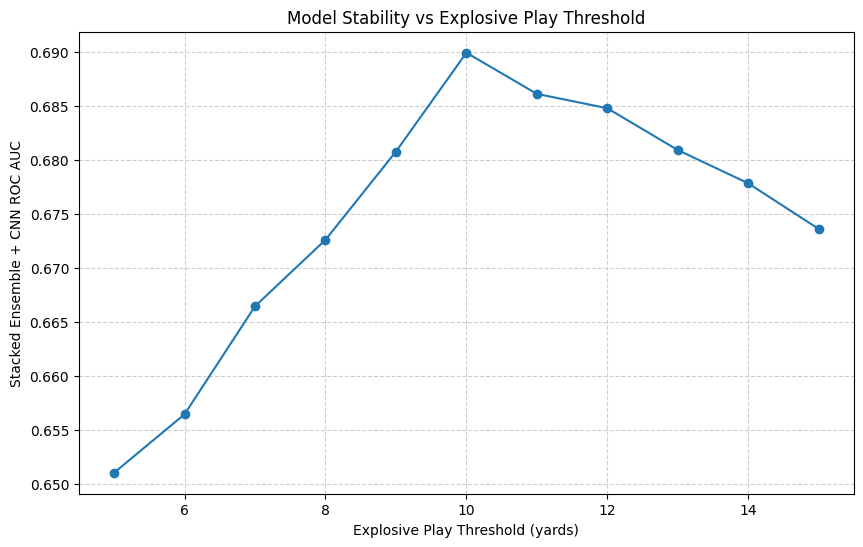

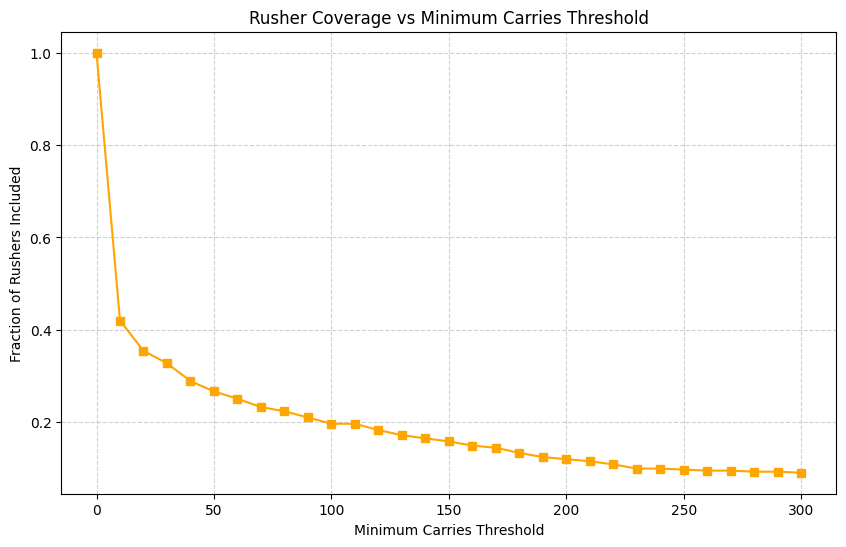

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# --- Parameters ---
EXPLOSIVE_THRESHOLDS = np.arange(5, 16, 1)       # explosive play thresholds 5 → 15 yards
CARRY_THRESHOLDS = np.arange(0, 301, 10)        # player min carries from 0 → 300
MIN_PLAYS = 5000                                  # minimum plays to include in model

# Store results
auc_results = []
coverage_results = []

# --- Graph 1: Model stability vs explosive play threshold ---
for yard_thr in EXPLOSIVE_THRESHOLDS:
    # Create temporary IsExplosive
    model_data['IsExplosiveTemp'] = (model_data['Yards'] >= yard_thr).astype(int)

    # Filter players with enough carries
    carry_counts = model_data.groupby('NflIdRusher')['PlayId'].count().reset_index().rename(columns={'PlayId':'NumCarries'})
    eligible_players = carry_counts[carry_counts['NumCarries'] >= MIN_CARRIES_FOR_MODEL]['NflIdRusher']
    filtered = model_data[model_data['NflIdRusher'].isin(eligible_players)].copy()

    if len(filtered) < MIN_PLAYS:
        continue

    # --- Recreate engineered features ---
    filtered['S*A'] = filtered['S'] * filtered['A']
    filtered['S^2'] = filtered['S'] ** 2
    filtered['A^2'] = filtered['A'] ** 2
    filtered['MinDistToRusher^2'] = filtered['MinDistToRusher'] ** 2
    filtered['S/MinDistToRusher'] = filtered['S'] / np.clip(filtered['MinDistToRusher'], 1e-3, None)
    filtered['Distance/YardLine'] = filtered['Distance'] / np.clip(filtered['YardLine'], 1e-3, None)

    # --- Tabular features ---
    X_tab = full_preprocessor.transform(filtered.drop(columns=context_features, errors='ignore'))
    X_tab = X_tab[:, feature_indices]

    # --- CNN OOF features ---
    idx_filtered = filtered.index.values
    X_cnn_feat = cnn_oof[idx_filtered].reshape(-1,1)

    # --- Combine level-1 + CNN ---
    X_level1_combined = np.hstack([X_level1[idx_filtered], X_cnn_feat])
    y_filtered = filtered['IsExplosiveTemp'].values

    # --- Predict ---
    preds = meta_learner.predict_proba(X_level1_combined)[:,1]
    auc_score = roc_auc_score(y_filtered, preds)
    auc_results.append((yard_thr, auc_score))

# Convert to DataFrame
auc_df = pd.DataFrame(auc_results, columns=['YardThreshold','AUC'])

# --- Plot Model Stability ---
plt.figure(figsize=(10,6))
plt.plot(auc_df['YardThreshold'], auc_df['AUC'], marker='o')
plt.xlabel('Explosive Play Threshold (yards)')
plt.ylabel('Stacked Ensemble + CNN ROC AUC')
plt.title('Model Stability vs Explosive Play Threshold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Graph 2: Rusher coverage vs minimum carries ---
for carry_thr in CARRY_THRESHOLDS:
    eligible_players = carry_counts[carry_counts['NumCarries'] >= carry_thr]['NflIdRusher']
    coverage_frac = len(eligible_players) / model_data['NflIdRusher'].nunique()
    coverage_results.append((carry_thr, coverage_frac))

coverage_df = pd.DataFrame(coverage_results, columns=['MinCarries','RusherCoverage'])

# --- Plot Rusher Coverage ---
plt.figure(figsize=(10,6))
plt.plot(coverage_df['MinCarries'], coverage_df['RusherCoverage'], marker='s', color='orange')
plt.xlabel('Minimum Carries Threshold')
plt.ylabel('Fraction of Rushers Included')
plt.title('Rusher Coverage vs Minimum Carries Threshold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [ ]:
# === REQUIRED IMPORTS ===
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
import tensorflow as tf

# --- Global Config ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
N_SPLITS = 5
EXPLOSIVE_YARDS_THRESHOLD = 10
TOP_FEATURES = 30
MIN_CARRIES_THRESHOLD = 50

# ==============================================================
# I. DATA LOADING AND FEATURE ENGINEERING
# ==============================================================
print("--- Step 1: Loading and Feature Engineering ---")
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path, low_memory=False)

numeric_cols = ['X', 'Y', 'S', 'A', 'YardLine', 'Distance', 'Yards']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

def engineer_features(df):
    rusher_cols = [
        'PlayId', 'Yards', 'Down', 'Distance', 'YardLine', 'OffenseFormation',
        'DefendersInTheBox', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
        'PossessionTeam', 'HomeTeamAbbr', 'S', 'A', 'NflIdRusher', 'DisplayName'
    ]
    rusher_df = df[df['NflId'] == df['NflIdRusher']].drop_duplicates(subset=['PlayId'])[rusher_cols].copy()
    rusher_pos_xy = df[df['NflId'] == df['NflIdRusher']][['PlayId', 'X', 'Y']].drop_duplicates()
    rusher_pos_xy.rename(columns={'X':'RusherX','Y':'RusherY'}, inplace=True)
    df_merged = pd.merge(df, rusher_pos_xy, on='PlayId', how='left')
    defenders_df = df_merged[df_merged['Team'] != df_merged['PossessionTeam']].copy()
    defenders_df['DistToRusher'] = np.sqrt((defenders_df['X']-defenders_df['RusherX'])**2 + (defenders_df['Y']-defenders_df['RusherY'])**2)
    defender_proximity = defenders_df.groupby('PlayId')['DistToRusher'].agg(MinDistToRusher=('min')).reset_index()
    model_df = pd.merge(rusher_df, defender_proximity, on='PlayId', how='left')
    model_df['ScoreDifferential'] = np.where(
        model_df['PossessionTeam']==model_df['HomeTeamAbbr'],
        model_df['HomeScoreBeforePlay']-model_df['VisitorScoreBeforePlay'],
        model_df['VisitorScoreBeforePlay']-model_df['HomeScoreBeforePlay']
    )
    model_df['YardsToGoal'] = model_df['YardLine']
    model_df['IsExplosive'] = (model_df['Yards']>=EXPLOSIVE_YARDS_THRESHOLD).astype(int)
    return model_df

model_data = engineer_features(df.copy())

# ==============================================================
# CNN FIELD TENSOR CONSTRUCTION
# ==============================================================
FIELD_LENGTH = 120.0
FIELD_WIDTH = 53.3
GRID_HEIGHT = 32
GRID_WIDTH = 32
NUM_CHANNELS = 4

def create_field_tensor_from_model_data(df_all, model_data_subset):
    plays = model_data_subset['PlayId'].values
    n = len(plays)
    tensor = np.zeros((n, GRID_HEIGHT, GRID_WIDTH, NUM_CHANNELS), dtype=np.float32)
    labels = np.zeros(n, dtype=int)
    rusher_pos = df_all[df_all['NflId'] == df_all['NflIdRusher']][['PlayId','X','Y']].drop_duplicates().set_index('PlayId')
    for i, pid in enumerate(plays):
        play_rows = df_all[df_all['PlayId'] == pid]
        labels[i] = int(model_data_subset.loc[model_data_subset['PlayId']==pid, 'IsExplosive'].values[0])
        if pid in rusher_pos.index:
            rusher_x = rusher_pos.at[pid, 'X']
            rusher_y = rusher_pos.at[pid, 'Y']
        else:
            rmask = play_rows['NflId'] == play_rows['NflIdRusher']
            rusher_x = play_rows[rmask]['X'].iloc[0] if rmask.any() else np.nan
            rusher_y = play_rows[rmask]['Y'].iloc[0] if rmask.any() else np.nan
        xb = np.clip((play_rows['X'] / FIELD_LENGTH * GRID_WIDTH).fillna(0).astype(int), 0, GRID_WIDTH-1)
        yb = np.clip((play_rows['Y'] / FIELD_WIDTH * GRID_HEIGHT).fillna(0).astype(int), 0, GRID_HEIGHT-1)
        rmask = play_rows['NflId'] == play_rows['NflIdRusher']
        for x,y in zip(xb[rmask], yb[rmask]):
            tensor[i,y,x,0] = 1.0
        if not np.isnan(rusher_x) and not np.isnan(rusher_y):
            defenders = play_rows[~rmask].copy()
            defenders_dist = np.sqrt((defenders['X'] - rusher_x)**2 + (defenders['Y'] - rusher_y)**2)
            for x,y,d in zip(xb[~rmask], yb[~rmask], defenders_dist):
                cur = tensor[i,y,x,1]
                val = d / 50.0
                tensor[i,y,x,1] = val if cur==0 else min(cur,val)
        for x,y,s in zip(xb, yb, play_rows['S']):
            tensor[i,y,x,2] = max(tensor[i,y,x,2], float(s) / 12.0)
        for x,y,a in zip(xb, yb, play_rows['A']):
            tensor[i,y,x,3] = max(tensor[i,y,x,3], float(a) / 6.0)
    return tensor, labels

X_cnn, Y_cnn = create_field_tensor_from_model_data(df, model_data)
print("CNN tensor shape (plays x H x W x C):", X_cnn.shape)
print("CNN labels shape:", Y_cnn.shape)

# ==============================================================
# TABULAR INPUT PREP
# ==============================================================
numerical_features = ['MinDistToRusher','YardsToGoal','ScoreDifferential','DefendersInTheBox','S','A','Distance']
categorical_features = ['Down','OffenseFormation']
context_features = ['NflIdRusher','DisplayName','PlayId','Yards','IsExplosive']

X_raw = model_data.drop(columns=context_features, errors='ignore')
Y_full = model_data['IsExplosive'].values

X_raw['S*A'] = X_raw['S'] * X_raw['A']
X_raw['S^2'] = X_raw['S'] ** 2
X_raw['A^2'] = X_raw['A'] ** 2
X_raw['MinDistToRusher^2'] = X_raw['MinDistToRusher'] ** 2
X_raw['S/MinDistToRusher'] = X_raw['S'] / np.clip(X_raw['MinDistToRusher'],1e-3,None)
X_raw['Distance/YardLine'] = X_raw['Distance'] / np.clip(X_raw['YardLine'],1e-3,None)
numerical_features += ['S*A','S^2','A^2','MinDistToRusher^2','S/MinDistToRusher','Distance/YardLine']

full_preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                      ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
], remainder='drop')

X_full = full_preprocessor.fit_transform(X_raw)
N_FEATURES = X_full.shape[1]
print(f"Tabular input features transformed. Total features: {N_FEATURES}")

# ==============================================================
# TOP FEATURE SELECTION
# ==============================================================
print("--- Step 2: Top Features via XGBoost (tabular) ---")
xgb_temp = xgb.XGBClassifier(objective='binary:logistic', n_estimators=150, max_depth=5, learning_rate=0.05,
                             eval_metric='auc', random_state=RANDOM_STATE, n_jobs=-1)
xgb_temp.fit(X_full, Y_full)
importances = xgb_temp.feature_importances_
feature_indices = np.argsort(importances)[::-1][:TOP_FEATURES]
X_full_selected = X_full[:, feature_indices]
print(f"Selected top {TOP_FEATURES} tabular features")

# ==============================================================
# STACKED ENSEMBLE + CNN
# ==============================================================
count_explosive = np.sum(Y_full==1)
count_non_explosive = np.sum(Y_full==0)
scale_weight = count_non_explosive / count_explosive

def create_mlp_model(input_dim, learning_rate=0.0005, dropout_rate=0.3, units=128):
    model = Sequential([
        BatchNormalization(input_shape=(input_dim,)),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(units//2, activation='relu'),
        Dropout(dropout_rate/2),
        Dense(units//4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

base_models_list = [
    ('MLPNN', KerasClassifier(model=lambda input_dim=X_full_selected.shape[1]: create_mlp_model(input_dim),
                              epochs=30, batch_size=64, verbose=0, random_state=RANDOM_STATE,
                              fit__class_weight={0:1,1:scale_weight})),
    ('XGBoost', xgb.XGBClassifier(objective='binary:logistic', n_estimators=400, max_depth=6, gamma=0.5,
                                  learning_rate=0.025, scale_pos_weight=scale_weight, random_state=RANDOM_STATE,
                                  use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3,
                                           class_weight={0:1,1:scale_weight}, random_state=RANDOM_STATE, n_jobs=-1))
]

def generate_oof_predictions(base_models, X_full_in, Y_full_in, n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros((X_full_in.shape[0], len(base_models)))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_in, Y_full_in)):
        X_train, X_val = X_full_in[train_idx], X_full_in[val_idx]
        Y_train, Y_val = Y_full_in[train_idx], Y_full_in[val_idx]
        for i, (name, model) in enumerate(base_models):
            model_fold = clone(model)
            model_fold.fit(X_train, Y_train)
            oof_preds[val_idx,i] = model_fold.predict_proba(X_val)[:,1]
    return oof_preds

print("--- Step 3: Training Tabular Base Models via OOF ---")
X_level1 = generate_oof_predictions(base_models_list, X_full_selected, Y_full)
print("Tabular level-1 shape:", X_level1.shape)

# --- CNN OOF ---
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32,(3,3),activation='relu',padding='same',input_shape=input_shape),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Conv2D(64,(3,3),activation='relu',padding='same'),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def generate_oof_cnn(X,y,n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof = np.zeros(len(X))
    for train_idx, val_idx in kf.split(X,y):
        model = create_cnn_model(X.shape[1:])
        model.fit(X[train_idx], y[train_idx], epochs=8, batch_size=32, verbose=0)
        oof[val_idx] = model.predict(X[val_idx]).flatten()
    return oof

print("--- Generating CNN OOF predictions (this may take a while) ---")
cnn_oof = generate_oof_cnn(X_cnn, Y_cnn, n_splits=N_SPLITS)
cnn_oof = cnn_oof.reshape(-1,1)
print("CNN OOF shape:", cnn_oof.shape)

# --- Combine tabular + CNN ---
X_level1_with_cnn = np.hstack([X_level1, cnn_oof])
print("Level-1 with CNN shape:", X_level1_with_cnn.shape)

# --- Meta learner ---
print("--- Step 4: Training Meta-Learner (with CNN) ---")
meta_learner = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=4,
                                 learning_rate=0.03, subsample=0.85, colsample_bytree=0.9,
                                 reg_lambda=1.2, reg_alpha=0.1, random_state=RANDOM_STATE,
                                 eval_metric='auc', n_jobs=-1)
meta_learner.fit(X_level1_with_cnn, Y_full)
oof_score = roc_auc_score(Y_full, meta_learner.predict_proba(X_level1_with_cnn)[:,1])
print(f"Stacked Ensemble + CNN OOF ROC AUC: {oof_score:.4f}")

# ==============================================================
# RUSHER-LEVEL AGGREGATION & DISPLAY
# ==============================================================
final_stacked_proba = meta_learner.predict_proba(X_level1_with_cnn)[:,1]
model_data['ProbExplosive'] = final_stacked_proba

rusher_bpr = model_data.groupby(['NflIdRusher']).agg(
    DisplayName=('DisplayName','first'),
    TotalCarries=('PlayId','count'),
    AvgPredictedBPR=('ProbExplosive','mean'),
    ActualBPR=('IsExplosive','mean')
).reset_index()

high_volume_rushers = rusher_bpr[rusher_bpr['TotalCarries']>=MIN_CARRIES_THRESHOLD].sort_values(by='TotalCarries',ascending=False).copy()

print("--- Final Rusher BPR Complete ---")
print(f"Total rushers: {rusher_bpr.shape[0]}")
print(f"High-volume rushers: {high_volume_rushers.shape[0]}")

def display_epr_differential_table(rusher_bpr, min_carries=MIN_CARRIES_THRESHOLD):
    EXPLOSIVE_YARDS_THRESHOLD = 10
    analysis_df = rusher_bpr[(rusher_bpr['TotalCarries']>=min_carries)&(rusher_bpr['DisplayName'].notna())].copy()
    analysis_df['EPR_Differential'] = analysis_df['ActualBPR']-analysis_df['AvgPredictedBPR']
    table_data = analysis_df.sort_values(by='EPR_Differential',ascending=False).copy()
    EPR_ACTUAL_COL = f'Actual EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    EPR_PREDICTED_COL = f'Predicted EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    DIFFERENTIAL_COL = 'EPR Differential (Actual - Predicted)'
    table_for_display = table_data[['DisplayName','TotalCarries','EPR_Differential','ActualBPR','AvgPredictedBPR']].rename(columns={
        'DisplayName':'Rusher Name','TotalCarries':'Carries','EPR_Differential':DIFFERENTIAL_COL,
        'ActualBPR':EPR_ACTUAL_COL,'AvgPredictedBPR':EPR_PREDICTED_COL
    }).reset_index(drop=True)
    styled_table = table_for_display.style.format({
        'Carries':'{:,.0f}',DIFFERENTIAL_COL:'{:+.2%}',EPR_ACTUAL_COL:'{:.2%}',EPR_PREDICTED_COL:'{:.2%}'
    }).background_gradient(cmap='coolwarm',subset=[DIFFERENTIAL_COL]).set_caption(
        f"Running Backs Ranked by Explosive Value Added (Min {min_carries} Carries)"
    )
    display(styled_table)

display_epr_differential_table(rusher_bpr)

--- Step 1: Loading and Feature Engineering ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CNN tensor shape (plays x H x W x C): (31007, 32, 32, 4)
CNN labels shape: (31007,)
Tabular input features transformed. Total features: 26
--- Step 2: Top Features via XGBoost (tabular) ---
Selected top 30 tabular features
--- Step 3: Training Tabular Base Models via OOF ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:14:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:15:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_la

Tabular level-1 shape: (31007, 3)
--- Generating CNN OOF predictions (this may take a while) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
CNN OOF shape: (31007, 1)
Level-1 with CNN shape: (31007, 4)
--- Step 4: Training Meta-Learner (with CNN) ---
Stacked Ensemble + CNN OOF ROC AUC: 0.6943
--- Final Rusher BPR Complete ---
Total rushers: 443
High-volume rushers: 118


,Rusher Name,Carries,EPR Differential (Actual - Predicted),Actual EPR (>10 Yds),Predicted EPR (>10 Yds)
0,Devin Singletary,84,+9.02%,20.24%,11.22%
1,Kenneth Dixon,60,+8.39%,18.33%,9.94%
2,Raheem Mostert,112,+6.37%,20.54%,14.16%
3,Cordarrelle Patterson,64,+6.36%,20.31%,13.95%
4,Alexander Mattison,82,+5.12%,17.07%,11.96%
5,Justin Jackson,70,+3.80%,15.71%,11.91%
6,Nick Chubb,412,+3.74%,13.59%,9.85%
7,Duke Johnson,181,+3.37%,14.92%,11.55%
8,Matt Breida,362,+3.08%,16.30%,13.22%
9,Jordan Wilkins,87,+2.98%,14.94%,11.96%


In [ ]:
# === REQUIRED IMPORTS ===
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
import tensorflow as tf

# --- Global Config ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
N_SPLITS = 5
EXPLOSIVE_YARDS_THRESHOLD = 10
TOP_FEATURES = 30
MIN_CARRIES_THRESHOLD = 50

# ==============================================================
# I. DATA LOADING AND FEATURE ENGINEERING
# ==============================================================
print("--- Step 1: Loading and Feature Engineering ---")
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(file_path, low_memory=False)

numeric_cols = ['X', 'Y', 'S', 'A', 'YardLine', 'Distance', 'Yards']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

def engineer_features(df):
    rusher_cols = [
        'PlayId', 'Yards', 'Down', 'Distance', 'YardLine', 'OffenseFormation',
        'DefendersInTheBox', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
        'PossessionTeam', 'HomeTeamAbbr', 'S', 'A', 'NflIdRusher', 'DisplayName'
    ]
    rusher_df = df[df['NflId'] == df['NflIdRusher']].drop_duplicates(subset=['PlayId'])[rusher_cols].copy()
    rusher_pos_xy = df[df['NflId'] == df['NflIdRusher']][['PlayId', 'X', 'Y']].drop_duplicates()
    rusher_pos_xy.rename(columns={'X':'RusherX','Y':'RusherY'}, inplace=True)
    df_merged = pd.merge(df, rusher_pos_xy, on='PlayId', how='left')
    defenders_df = df_merged[df_merged['Team'] != df_merged['PossessionTeam']].copy()
    defenders_df['DistToRusher'] = np.sqrt((defenders_df['X']-defenders_df['RusherX'])**2 + (defenders_df['Y']-defenders_df['RusherY'])**2)
    defender_proximity = defenders_df.groupby('PlayId')['DistToRusher'].agg(MinDistToRusher=('min')).reset_index()
    model_df = pd.merge(rusher_df, defender_proximity, on='PlayId', how='left')
    model_df['ScoreDifferential'] = np.where(
        model_df['PossessionTeam']==model_df['HomeTeamAbbr'],
        model_df['HomeScoreBeforePlay']-model_df['VisitorScoreBeforePlay'],
        model_df['VisitorScoreBeforePlay']-model_df['HomeScoreBeforePlay']
    )
    model_df['YardsToGoal'] = model_df['YardLine']
    model_df['IsExplosive'] = (model_df['Yards']>=EXPLOSIVE_YARDS_THRESHOLD).astype(int)
    return model_df

model_data = engineer_features(df.copy())

# ==============================================================
# CNN FIELD TENSOR CONSTRUCTION
# ==============================================================
FIELD_LENGTH = 120.0
FIELD_WIDTH = 53.3
GRID_HEIGHT = 32
GRID_WIDTH = 32
NUM_CHANNELS = 4

def create_field_tensor_from_model_data(df_all, model_data_subset):
    plays = model_data_subset['PlayId'].values
    n = len(plays)
    tensor = np.zeros((n, GRID_HEIGHT, GRID_WIDTH, NUM_CHANNELS), dtype=np.float32)
    labels = np.zeros(n, dtype=int)
    rusher_pos = df_all[df_all['NflId'] == df_all['NflIdRusher']][['PlayId','X','Y']].drop_duplicates().set_index('PlayId')
    for i, pid in enumerate(plays):
        play_rows = df_all[df_all['PlayId'] == pid]
        labels[i] = int(model_data_subset.loc[model_data_subset['PlayId']==pid, 'IsExplosive'].values[0])
        if pid in rusher_pos.index:
            rusher_x = rusher_pos.at[pid, 'X']
            rusher_y = rusher_pos.at[pid, 'Y']
        else:
            rmask = play_rows['NflId'] == play_rows['NflIdRusher']
            rusher_x = play_rows[rmask]['X'].iloc[0] if rmask.any() else np.nan
            rusher_y = play_rows[rmask]['Y'].iloc[0] if rmask.any() else np.nan
        xb = np.clip((play_rows['X'] / FIELD_LENGTH * GRID_WIDTH).fillna(0).astype(int), 0, GRID_WIDTH-1)
        yb = np.clip((play_rows['Y'] / FIELD_WIDTH * GRID_HEIGHT).fillna(0).astype(int), 0, GRID_HEIGHT-1)
        rmask = play_rows['NflId'] == play_rows['NflIdRusher']
        for x,y in zip(xb[rmask], yb[rmask]):
            tensor[i,y,x,0] = 1.0
        if not np.isnan(rusher_x) and not np.isnan(rusher_y):
            defenders = play_rows[~rmask].copy()
            defenders_dist = np.sqrt((defenders['X'] - rusher_x)**2 + (defenders['Y'] - rusher_y)**2)
            for x,y,d in zip(xb[~rmask], yb[~rmask], defenders_dist):
                cur = tensor[i,y,x,1]
                val = d / 50.0
                tensor[i,y,x,1] = val if cur==0 else min(cur,val)
        for x,y,s in zip(xb, yb, play_rows['S']):
            tensor[i,y,x,2] = max(tensor[i,y,x,2], float(s) / 12.0)
        for x,y,a in zip(xb, yb, play_rows['A']):
            tensor[i,y,x,3] = max(tensor[i,y,x,3], float(a) / 6.0)
    return tensor, labels

X_cnn, Y_cnn = create_field_tensor_from_model_data(df, model_data)
print("CNN tensor shape (plays x H x W x C):", X_cnn.shape)
print("CNN labels shape:", Y_cnn.shape)

# ==============================================================
# TABULAR INPUT PREP
# ==============================================================
numerical_features = ['MinDistToRusher','YardsToGoal','ScoreDifferential','DefendersInTheBox','S','A','Distance']
categorical_features = ['Down','OffenseFormation']
context_features = ['NflIdRusher','DisplayName','PlayId','Yards','IsExplosive']

X_raw = model_data.drop(columns=context_features, errors='ignore')
Y_full = model_data['IsExplosive'].values

X_raw['S*A'] = X_raw['S'] * X_raw['A']
X_raw['S^2'] = X_raw['S'] ** 2
X_raw['A^2'] = X_raw['A'] ** 2
X_raw['MinDistToRusher^2'] = X_raw['MinDistToRusher'] ** 2
X_raw['S/MinDistToRusher'] = X_raw['S'] / np.clip(X_raw['MinDistToRusher'],1e-3,None)
X_raw['Distance/YardLine'] = X_raw['Distance'] / np.clip(X_raw['YardLine'],1e-3,None)
numerical_features += ['S*A','S^2','A^2','MinDistToRusher^2','S/MinDistToRusher','Distance/YardLine']

full_preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                      ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
], remainder='drop')

X_full = full_preprocessor.fit_transform(X_raw)
N_FEATURES = X_full.shape[1]
print(f"Tabular input features transformed. Total features: {N_FEATURES}")

# ==============================================================
# TOP FEATURE SELECTION
# ==============================================================
print("--- Step 2: Top Features via XGBoost (tabular) ---")
xgb_temp = xgb.XGBClassifier(objective='binary:logistic', n_estimators=150, max_depth=5, learning_rate=0.05,
                             eval_metric='auc', random_state=RANDOM_STATE, n_jobs=-1)
xgb_temp.fit(X_full, Y_full)
importances = xgb_temp.feature_importances_
feature_indices = np.argsort(importances)[::-1][:TOP_FEATURES]
X_full_selected = X_full[:, feature_indices]
print(f"Selected top {TOP_FEATURES} tabular features")

# ==============================================================
# STACKED ENSEMBLE + CNN
# ==============================================================
count_explosive = np.sum(Y_full==1)
count_non_explosive = np.sum(Y_full==0)
scale_weight = count_non_explosive / count_explosive

def create_mlp_model(input_dim, learning_rate=0.0005, dropout_rate=0.3, units=128):
    model = Sequential([
        BatchNormalization(input_shape=(input_dim,)),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(units//2, activation='relu'),
        Dropout(dropout_rate/2),
        Dense(units//4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['AUC'])
    return model

base_models_list = [
    ('MLPNN', KerasClassifier(model=lambda input_dim=X_full_selected.shape[1]: create_mlp_model(input_dim),
                              epochs=30, batch_size=64, verbose=0, random_state=RANDOM_STATE,
                              fit__class_weight={0:1,1:scale_weight})),
    ('XGBoost', xgb.XGBClassifier(objective='binary:logistic', n_estimators=400, max_depth=6, gamma=0.5,
                                  learning_rate=0.025, scale_pos_weight=scale_weight, random_state=RANDOM_STATE,
                                  use_label_encoder=False, eval_metric='logloss', n_jobs=-1)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3,
                                           class_weight={0:1,1:scale_weight}, random_state=RANDOM_STATE, n_jobs=-1))
]

def generate_oof_predictions(base_models, X_full_in, Y_full_in, n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros((X_full_in.shape[0], len(base_models)))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_in, Y_full_in)):
        X_train, X_val = X_full_in[train_idx], X_full_in[val_idx]
        Y_train, Y_val = Y_full_in[train_idx], Y_full_in[val_idx]
        for i, (name, model) in enumerate(base_models):
            model_fold = clone(model)
            model_fold.fit(X_train, Y_train)
            oof_preds[val_idx,i] = model_fold.predict_proba(X_val)[:,1]
    return oof_preds

print("--- Step 3: Training Tabular Base Models via OOF ---")
X_level1 = generate_oof_predictions(base_models_list, X_full_selected, Y_full)
print("Tabular level-1 shape:", X_level1.shape)

# --- CNN OOF ---
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32,(3,3),activation='relu',padding='same',input_shape=input_shape),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Conv2D(64,(3,3),activation='relu',padding='same'),
        MaxPooling2D((2,2)),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def generate_oof_cnn(X,y,n_splits=N_SPLITS):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof = np.zeros(len(X))
    for train_idx, val_idx in kf.split(X,y):
        model = create_cnn_model(X.shape[1:])
        model.fit(X[train_idx], y[train_idx], epochs=8, batch_size=32, verbose=0)
        oof[val_idx] = model.predict(X[val_idx]).flatten()
    return oof

print("--- Generating CNN OOF predictions (this may take a while) ---")
cnn_oof = generate_oof_cnn(X_cnn, Y_cnn, n_splits=N_SPLITS)
cnn_oof = cnn_oof.reshape(-1,1)
print("CNN OOF shape:", cnn_oof.shape)

# --- Combine tabular + CNN ---
X_level1_with_cnn = np.hstack([X_level1, cnn_oof])
print("Level-1 with CNN shape:", X_level1_with_cnn.shape)

# --- Meta learner ---
print("--- Step 4: Training Meta-Learner (with CNN) ---")
meta_learner = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=4,
                                 learning_rate=0.03, subsample=0.85, colsample_bytree=0.9,
                                 reg_lambda=1.2, reg_alpha=0.1, random_state=RANDOM_STATE,
                                 eval_metric='auc', n_jobs=-1)
meta_learner.fit(X_level1_with_cnn, Y_full)
oof_score = roc_auc_score(Y_full, meta_learner.predict_proba(X_level1_with_cnn)[:,1])
print(f"Stacked Ensemble + CNN OOF ROC AUC: {oof_score:.4f}")

# ==============================================================
# RUSHER-LEVEL AGGREGATION & DISPLAY
# ==============================================================
final_stacked_proba = meta_learner.predict_proba(X_level1_with_cnn)[:,1]
model_data['ProbExplosive'] = final_stacked_proba

rusher_bpr = model_data.groupby(['NflIdRusher']).agg(
    DisplayName=('DisplayName','first'),
    TotalCarries=('PlayId','count'),
    AvgPredictedBPR=('ProbExplosive','mean'),
    ActualBPR=('IsExplosive','mean')
).reset_index()

high_volume_rushers = rusher_bpr[rusher_bpr['TotalCarries']>=MIN_CARRIES_THRESHOLD].sort_values(by='TotalCarries',ascending=False).copy()

print("--- Final Rusher BPR Complete ---")
print(f"Total rushers: {rusher_bpr.shape[0]}")
print(f"High-volume rushers: {high_volume_rushers.shape[0]}")

def display_epr_differential_table(rusher_bpr, min_carries=MIN_CARRIES_THRESHOLD):
    EXPLOSIVE_YARDS_THRESHOLD = 10

    analysis_df = rusher_bpr[
        (rusher_bpr['TotalCarries'] >= min_carries) &
        (rusher_bpr['DisplayName'].notna())
    ].copy()

    analysis_df['EPR_Differential'] = (
        analysis_df['ActualBPR'] - analysis_df['AvgPredictedBPR']
    )

    table_data = analysis_df.sort_values(
        by='EPR_Differential', ascending=False
    ).copy()

    # Column names
    EPR_ACTUAL_COL = f'Actual EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    EPR_PREDICTED_COL = f'Predicted EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    DIFFERENTIAL_COL = 'EPR Differential (Actual - Predicted)'

    table_for_display = table_data[
        ['DisplayName','TotalCarries','EPR_Differential','ActualBPR','AvgPredictedBPR']
    ].rename(columns={
        'DisplayName':'Rusher Name',
        'TotalCarries':'Carries',
        'EPR_Differential':DIFFERENTIAL_COL,
        'ActualBPR':EPR_ACTUAL_COL,
        'AvgPredictedBPR':EPR_PREDICTED_COL
    }).reset_index(drop=True)

    # ---- STYLE TABLE ----
    styled_table = (
        table_for_display.style
        .format({
            'Carries': '{:,.0f}',
            DIFFERENTIAL_COL: '{:+.2%}',
            EPR_ACTUAL_COL: '{:.2%}',
            EPR_PREDICTED_COL: '{:.2%}',
        })
        .background_gradient(cmap='coolwarm', subset=[DIFFERENTIAL_COL])
        .set_caption(
            f"Running Backs Ranked by Explosive Value Added (Min {min_carries} Carries)"
        )
    )

    # Display to notebook
    display(styled_table)

    # 🔥 MOST IMPORTANT PART: RETURN IT
    return styled_table

--- Step 1: Loading and Feature Engineering ---
Mounted at /content/drive
CNN tensor shape (plays x H x W x C): (31007, 32, 32, 4)
CNN labels shape: (31007,)
Tabular input features transformed. Total features: 26
--- Step 2: Top Features via XGBoost (tabular) ---
Selected top 30 tabular features
--- Step 3: Training Tabular Base Models via OOF ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:26:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:27:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_la

Tabular level-1 shape: (31007, 3)
--- Generating CNN OOF predictions (this may take a while) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
CNN OOF shape: (31007, 1)
Level-1 with CNN shape: (31007, 4)
--- Step 4: Training Meta-Learner (with CNN) ---
Stacked Ensemble + CNN OOF ROC AUC: 0.6932
--- Final Rusher BPR Complete ---
Total rushers: 443
High-volume rushers: 118


In [ ]:
styled_table = display_epr_differential_table(rusher_bpr)

,Rusher Name,Carries,EPR Differential (Actual - Predicted),Actual EPR (>10 Yds),Predicted EPR (>10 Yds)
0,Devin Singletary,84,+9.13%,20.24%,11.11%
1,Kenneth Dixon,60,+8.61%,18.33%,9.73%
2,Cordarrelle Patterson,64,+6.61%,20.31%,13.70%
3,Raheem Mostert,112,+6.36%,20.54%,14.18%
4,Alexander Mattison,82,+5.28%,17.07%,11.79%
5,Nick Chubb,412,+3.67%,13.59%,9.92%
6,Justin Jackson,70,+3.46%,15.71%,12.25%
7,Duke Johnson,181,+3.43%,14.92%,11.49%
8,Matt Breida,362,+3.13%,16.30%,13.17%
9,Jordan Wilkins,87,+3.01%,14.94%,11.93%


In [ ]:
!apt-get install -y wkhtmltopdf
!pip install imgkit


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core avahi-daemon geoclue-2.0 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gstreamer1.0-plugins-base
  iio-sensor-proxy libatk-bridge2.0-0 libatk1.0-0 libatk1.0-data libatspi2.0-0
  libavahi-core7 libavahi-glib1 libcdparanoia0 libdaemon0
  libdouble-conversion3 libevdev2 libgstreamer-plugins-base1.0-0 libgtk-3-0
  libgtk-3-bin libgtk-3-common libgudev-1.0-0 libhyphen0 libinput-bin
  libinput10 libjson-glib-1.0-0 libjson-glib-1.0-common libmbim-glib4
  libmbim-proxy libmd4c0 libmm-glib0 libmtdev1 libnl-genl-3-200 libnotify4
  libnss-mdns liborc-0.4-0 libproxy1v5 libqmi-glib5 libqmi-proxy libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5positioning5 libqt5printsupport5
  libqt5qml5 libqt5qmlmodels5 libqt5quick5 libqt5sensors5 libqt5svg5
  libqt5webchannel5 libqt5webkit5 libq

In [ ]:
html_path = "/content/epr_table.html"
png_path = "/content/epr_table.png"

html = styled_table.to_html()

with open(html_path, "w") as f:
    f.write(html)


In [ ]:
def display_epr_differential_table(rusher_bpr, min_carries=MIN_CARRIES_THRESHOLD):
    EXPLOSIVE_YARDS_THRESHOLD = 10
    analysis_df = rusher_bpr[(rusher_bpr['TotalCarries']>=min_carries)&(rusher_bpr['DisplayName'].notna())].copy()
    analysis_df['EPR_Differential'] = analysis_df['ActualBPR'] - analysis_df['AvgPredictedBPR']

    table_data = analysis_df.sort_values(by='EPR_Differential', ascending=False).copy()

    EPR_ACTUAL_COL = f'Actual EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    EPR_PREDICTED_COL = f'Predicted EPR (>{EXPLOSIVE_YARDS_THRESHOLD} Yds)'
    DIFFERENTIAL_COL = 'EPR Differential (Actual - Predicted)'

    table_for_display = table_data[['DisplayName','TotalCarries','EPR_Differential','ActualBPR','AvgPredictedBPR']].rename(columns={
        'DisplayName':'Rusher Name',
        'TotalCarries':'Carries',
        'EPR_Differential':DIFFERENTIAL_COL,
        'ActualBPR':EPR_ACTUAL_COL,
        'AvgPredictedBPR':EPR_PREDICTED_COL
    }).reset_index(drop=True)

    styled_table = table_for_display.style.format({
        'Carries':'{:,.0f}',
        DIFFERENTIAL_COL:'{:+.2%}',
        EPR_ACTUAL_COL:'{:.2%}',
        EPR_PREDICTED_COL:'{:.2%}'
    }).background_gradient(cmap='coolwarm', subset=[DIFFERENTIAL_COL]).set_caption(
        f"Running Backs Ranked by Explosive Value Added (Min {min_carries} Carries)"
    )

    display(styled_table)

    return styled_table


NameError: name 'MIN_CARRIES_THRESHOLD' is not defined

In [ ]:
import imgkit

imgkit.from_file(html_path, png_path)
print("Saved image:", png_path)


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Saved image: /content/epr_table.png


In [ ]:
from google.colab import files
files.download("/content/epr_table.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>